# Question 3: Lyrics Generation using RNN

# Importing Dependencies




In [1]:
import tensorflow as tf
import numpy as np
import os
import time
import pandas as pd

# Saving lyrics in a text file 

In [2]:
df = pd.read_csv('LYRICS_DATASET.csv')
df.head()

,Artist Name,Song Name,Lyrics
0,Phoebe Bridgers,Motion Sickness,I hate you for what you did And I miss you li...
1,Phoebe Bridgers,Killer,Sometimes I think I'm a killer I scared you i...
2,Phoebe Bridgers,Georgia,"Georgia, Georgia, I love your son And when he..."
3,Phoebe Bridgers,Kyoto,Day off in Kyoto Got bored at the temple Look...
4,Phoebe Bridgers,Would You Rather,"Playing ""would you rather"" When it comes to f..."


In [3]:
df['Lyrics'].to_csv(r'all_lyrics.txt', header=None, index=None, sep='\n', mode='a')

# Part 1

### Reading all_lyrics.txt

In [2]:
path_to_file = 'all_lyrics.txt'

In [3]:
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')

print ('{} characters'.format(len(text)))

389962 characters


In [4]:
print(text[:50])

I hate you for what you did
And I miss you like a 


### Getting a list of unique characters

In [5]:
vocab = sorted(set(text))
print ('{} unique characters'.format(len(vocab)))

97 unique characters


#### Pre-processing
The model doesn't understand characters. So we need to convert it into **numbers**. Here we'll going to build a dictionary for character=>number and number=>character.

In [6]:
char2idx = {u:i for i, u in enumerate(vocab)}
idx2char = np.array(vocab)

text_as_int = np.array([char2idx[c] for c in text])

In [7]:
for char,_ in zip(char2idx, range(20)):
    print('  {:4s}: {:3d},'.format(repr(char), char2idx[char]))

  '\n':   0,
  ' ' :   1,
  '!' :   2,
  '"' :   3,
  '&' :   4,
  "'" :   5,
  '(' :   6,
  ')' :   7,
  '*' :   8,
  ',' :   9,
  '-' :  10,
  '.' :  11,
  '/' :  12,
  '0' :  13,
  '1' :  14,
  '2' :  15,
  '3' :  16,
  '4' :  17,
  '5' :  18,
  '6' :  19,


Let's say we want to map this string to intergers:


>  I hate you for what



In [8]:
print ('{}  {}'.format(repr(text[:20]), text_as_int[:20]))

'I hate you for what '  [34  1 60 53 72 57  1 77 67 73  1 58 67 70  1 75 60 53 72  1]


### Creating training examples and targets
Here we're going to break the text into sequence of seq_length + 1 , for example let' say the string is Hello:

*   Then input sequence becomes : "Hell"
*   The output sequence becomes : "ello"

In [9]:
seq_length = 100
examples_per_epoch = len(text)//(seq_length+1)

char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)

for i in char_dataset.take(5):
  print(idx2char[i.numpy()] , end = "")

I hat

In [10]:
sequences = char_dataset.batch(seq_length+1, drop_remainder=True)

for item in sequences.take(5):
  print(repr(''.join(idx2char[item.numpy()])))

"I hate you for what you did\nAnd I miss you like a little kid\nI faked it every time\nBut that's alright"
'\nI can hardly feel anything\nI hardly feel anything at all\nYou gave me fifteen hundred\nTo see your hyp'
'notherapist\nI only went one time\nYou let it slide\nFell on hard times a year ago\nWas hoping you would '
'let it go, and you did\nI have emotional motion sickness\nSomebody roll the windows down\nThere are no w'
"ords in the English language\nI could scream to drown you out\nI'm on the outside looking through\nYou'r"


### Mapping function
This function will split a string into input and target format:

In [11]:
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

dataset = sequences.map(split_input_target)

### Creating training batches

In [12]:
# Batch size
BATCH_SIZE = 64
BUFFER_SIZE = 10000
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
dataset

<BatchDataset shapes: ((64, 100), (64, 100)), types: (tf.int64, tf.int64)>

In [13]:
vocab_size = len(vocab)

embedding_dim = 256

rnn_units = 1500

### Define the model
**1. Embedding layer :** The input layer. A trainable lookup table that will map the numbers of each character to a vector with embedding_dim dimensions

**2. GRU layer :** A type of RNN with size units=rnn_units (LSTM could also be used here.)

**3. Dense layer :** The output layer, with vocab_size outputs and 'RELU' as the activation fuction 

**4. Dropout layer :** Benifits regularisation and prevents overfitting  


In [38]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
  model = tf.keras.Sequential([
                               
    tf.keras.layers.Embedding(vocab_size, embedding_dim,
                              batch_input_shape=[batch_size, None]),
  
    tf.keras.layers.GRU(rnn_units,
                        return_sequences=True,
                        stateful=True,
                        recurrent_initializer='glorot_uniform'),

    tf.keras.layers.Dense(vocab_size,activation='relu'),
    
    tf.keras.layers.Dropout(0.2),
  ])
  return model

In [39]:
model = build_model(
  vocab_size = len(vocab),
  embedding_dim=embedding_dim,
  rnn_units=rnn_units,
  batch_size=BATCH_SIZE)

In [40]:
for input_example_batch, target_example_batch in dataset.take(1):
  example_batch_predictions = model(input_example_batch)
  print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 100, 97) # (batch_size, sequence_length, vocab_size)


In [41]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (64, None, 256)           24832     
                                                                 
 gru_2 (GRU)                 (64, None, 1500)          7911000   
                                                                 
 dense_2 (Dense)             (64, None, 97)            145597    
                                                                 
 dropout_2 (Dropout)         (64, None, 97)            0         
                                                                 
Total params: 8,081,429
Trainable params: 8,081,429
Non-trainable params: 0
_________________________________________________________________


In [42]:
def loss(labels, logits):
  return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

example_batch_loss  = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("scalar_loss:      ", example_batch_loss.numpy().mean())

Prediction shape:  (64, 100, 97)  # (batch_size, sequence_length, vocab_size)
scalar_loss:       4.5752373


In [43]:
model.compile(optimizer='adam', loss=loss)

### Training

In [44]:
EPOCHS=15

In [45]:
history = model.fit(dataset, epochs=EPOCHS)

Epoch 1/15
60/60 [==============================] - 16s 226ms/step - loss: 3.8047
Epoch 2/15
60/60 [==============================] - 14s 230ms/step - loss: 3.0052
Epoch 3/15
60/60 [==============================] - 14s 226ms/step - loss: 2.8308
Epoch 4/15
60/60 [==============================] - 14s 230ms/step - loss: 2.6977
Epoch 5/15
60/60 [==============================] - 14s 229ms/step - loss: 2.5962
Epoch 6/15
60/60 [==============================] - 14s 226ms/step - loss: 2.5086
Epoch 7/15
60/60 [==============================] - 14s 230ms/step - loss: 2.4329
Epoch 8/15
60/60 [==============================] - 15s 230ms/step - loss: 2.3640
Epoch 9/15
60/60 [==============================] - 14s 231ms/step - loss: 2.3023
Epoch 10/15
60/60 [==============================] - 14s 228ms/step - loss: 2.2419
Epoch 11/15
60/60 [==============================] - 14s 227ms/step - loss: 2.1842
Epoch 12/15
60/60 [==============================] - 14s 230ms/step - loss: 2.1323
Epoch 13/15
6

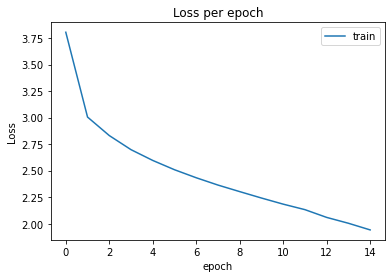

In [46]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.title('Loss per epoch')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper right')
plt.show()

### Part B: Trying different loss functions

### 1. Sparse Categorical Crossentropy
In part A, we use sparse_categorical_crossentropy as loss function.

**loss = 1.2670**



### 2. Mean Squared Error(MSE)

**loss = 6.6186**



In [ ]:
model = build_model(
  vocab_size = len(vocab),
  embedding_dim=embedding_dim,
  rnn_units=rnn_units,
  batch_size=BATCH_SIZE)

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
history = model.fit(dataset, epochs=EPOCHS)

Epoch 1/15
60/60 [==============================] - 17s 251ms/step - loss: 5.6347
Epoch 2/15
60/60 [==============================] - 15s 248ms/step - loss: 5.3683
Epoch 3/15
60/60 [==============================] - 15s 248ms/step - loss: 5.4342
Epoch 4/15
60/60 [==============================] - 16s 249ms/step - loss: 5.4868
Epoch 5/15
60/60 [==============================] - 16s 249ms/step - loss: 6.8124
Epoch 6/15
60/60 [==============================] - 15s 247ms/step - loss: 6.5915
Epoch 7/15
60/60 [==============================] - 15s 248ms/step - loss: 6.5700
Epoch 8/15
60/60 [==============================] - 15s 248ms/step - loss: 6.5898
Epoch 9/15
60/60 [==============================] - 15s 246ms/step - loss: 6.5908
Epoch 10/15
60/60 [==============================] - 15s 246ms/step - loss: 6.6023
Epoch 11/15
60/60 [==============================] - 15s 246ms/step - loss: 6.6229
Epoch 12/15
60/60 [==============================] - 15s 245ms/step - loss: 6.6020
Epoch 13/15
6

### 3. Mean Absolute Error(MAE)

**loss = 1.2670**



In [ ]:
model = build_model(
  vocab_size = len(vocab),
  embedding_dim=embedding_dim,
  rnn_units=rnn_units,
  batch_size=BATCH_SIZE)

In [ ]:
model.compile(optimizer='adam', loss='mean_absolute_error')

In [ ]:
history = model.fit(dataset, epochs=EPOCHS)

Epoch 1/15
60/60 [==============================] - 17s 251ms/step - loss: 6.0171
Epoch 2/15
60/60 [==============================] - 15s 248ms/step - loss: 5.5608
Epoch 3/15
60/60 [==============================] - 16s 250ms/step - loss: 5.3678
Epoch 4/15
60/60 [==============================] - 15s 248ms/step - loss: 5.5201
Epoch 5/15
60/60 [==============================] - 16s 248ms/step - loss: 5.6483
Epoch 6/15
60/60 [==============================] - 15s 246ms/step - loss: 5.5909
Epoch 7/15
60/60 [==============================] - 15s 246ms/step - loss: 5.4458
Epoch 8/15
60/60 [==============================] - 15s 245ms/step - loss: 5.5188
Epoch 9/15
60/60 [==============================] - 15s 246ms/step - loss: 5.5100
Epoch 10/15
60/60 [==============================] - 15s 248ms/step - loss: 5.6828
Epoch 11/15
60/60 [==============================] - 15s 246ms/step - loss: 5.5550
Epoch 12/15
60/60 [==============================] - 15s 247ms/step - loss: 5.6820
Epoch 13/15
6

### Part C: Generating new lyrics

In [ ]:
def generate_text(model, chars_to_generate , temp , start_string):
  num_generate = chars_to_generate

  input_eval = [char2idx[s] for s in start_string]
  input_eval = tf.expand_dims(input_eval, 0)

  text_generated = []

  temperature = temp

  model.reset_states()
  for i in range(num_generate):
      predictions = model(input_eval)

      predictions = tf.squeeze(predictions, 0)

      predictions = predictions / temperature
      predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()

      input_eval = tf.expand_dims([predicted_id], 0)

      text_generated.append(idx2char[predicted_id])

  return (start_string + ''.join(text_generated))

In [ ]:
from numpy import arange

chars_to_generate = 500 

print(generate_text(model , chars_to_generate , 0.35 , start_string=u"Baby "))

Baby out to the sturt gives to make it because I believe in us
Tell me how long
There's a fire too much
I think I love you better now
I'm in love with your body


Oh honey
I see the stars are the floor
Masier the summer
That you can see the stars that we say


But I will never be the same


But the fell in love with your body
Oh many times, how many times, how much I wanna see you now
I see the sumeching back a shoulders
I'm sunch in the back of my through
The sun line the lovers we need
Like the sta
